In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/Documents/projects/practice/general/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
2024-06-11 12:54:34.659233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 12:54:35.558955: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2024-06-11 12:54:35.559023: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could n

In [4]:
series = read_csv('../data/single bill for cluster 0.csv', usecols=[1], engine='python')
series00 = read_csv('../data/single bill cluster 00.csv', usecols=[1], engine='python')
series000 = read_csv('../data/single bill cluster 000.csv', usecols=[1], engine='python')
series0000 = read_csv('../data/single bill cluster 0000.csv', usecols=[1], engine='python')
series00000 = read_csv('../data/single bill cluster 00000.csv', usecols=[1], engine='python')

# transform data to be stationary
raw_values = series.values
raw_values00 = series00.values
raw_values000 = series000.values
raw_values0000 = series0000.values
raw_values00000 = series00000.values

In [7]:
series2 = read_csv('../data/single bill for cluster 1.csv', usecols=[1], engine='python')
series22 = read_csv('../data/single bill culster 11.csv', usecols=[1], engine='python')
series222 = read_csv('../data/single bill culster 111.csv', usecols=[1], engine='python')
series2222 = read_csv('../data/single bill for cluster 1111.csv', usecols=[1], engine='python')
series22222 = read_csv('../data/single bill culster 11111.csv', usecols=[1], engine='python')


# transform data to be stationary
raw_values2 = series2.values
raw_values22 = series22.values
raw_values222 = series222.values
raw_values2222 = series2222.values
raw_values22222 = series22222.values


In [11]:
series3 = read_csv('../data/single bill for cluster 2.csv .csv', usecols=[1], engine='python')
series33 = read_csv('../data/single bill culster 22.csv', usecols=[1], engine='python')
series333 = read_csv('../data/single bill culster 222.csv', usecols=[1], engine='python')
series3333 = read_csv('../data/single bill culster 2222.csv', usecols=[1], engine='python')
series33333 = read_csv('../data/single bill cluster 22222.csv', usecols=[1], engine='python')


# transform data to be stationary
raw_values3 = series3.values
raw_values33 = series33.values
raw_values333 = series333.values
raw_values3333 = series3333.values
raw_values33333 = series33333.values

In [12]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [13]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [14]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons, patience=3):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')

	early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)

	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, callbacks=[early_stopping])
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [25]:
### Global Variables
NB_EPOCH = 10
NEURONS = 32
BATCH_SIZE = 1

### For Cluster 0

In [18]:
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[ 0.00729403],
       [-0.6270485 ],
       [ 0.35158902],
       [-0.1698263 ],
       [ 0.21651608],
       [-0.13544971],
       [ 0.22971147],
       [ 0.2510349 ],
       [-0.16130535],
       [-0.44734985],
       [-0.04019699],
       [-0.18883114],
       [ 0.5415691 ],
       [ 0.06112079],
       [ 0.28427756],
       [-0.16015945],
       [-0.27165407],
       [-0.20883793],
       [ 0.56262726],
       [-0.10639965],
       [-0.2817792 ],
       [ 0.45306545],
       [-0.13501579],
       [ 0.4449569 ],
       [-0.28055692],
       [-0.22565192],
       [ 0.46075568],
       [-0.06667756],
       [-0.02021682],
       [-0.18724397],
       [ 0.0577199 ],
       [ 0.0587724 ],
       [ 0.3410626 ],
       [ 0.14527217],
       [-0.32136908],
       [ 0.651006  ],
       [-0.09681633],
       [-0.24650583],
       [ 0.11924087],
       [-0.23559229],
       [ 0.5350661 ],
       [ 0.06101393],
       [ 0.37796646],
       [-0.15414916]], dtype=float32)

In [19]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 18ms/step
Month=1, Predicted=1139.427122, Expected=2107.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=1409.837568, Expected=1324.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=1571.794779, Expected=1050.000000


Test RMSE: 636.615
Test MAE: 525.068


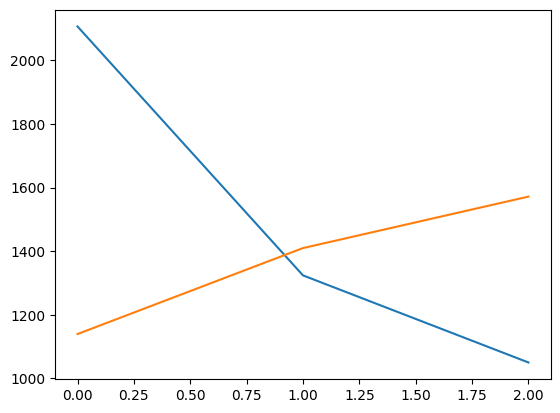

In [22]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=1208.711401, Expected=2107.000000
1/1 [==============================] - 0s 15ms/step
Month=2, Predicted=2366.014919, Expected=1324.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=1486.664329, Expected=1050.000000
Test RMSE: 833.345
Test MAE: 792.323


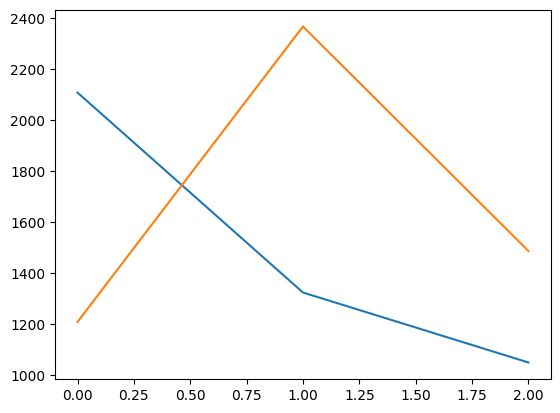

In [23]:
diff_values = difference(raw_values00, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=-427.566644, Expected=2107.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=1431.352567, Expected=1324.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=1300.730729, Expected=1050.000000
Test RMSE: 1471.781
Test MAE: 964.217


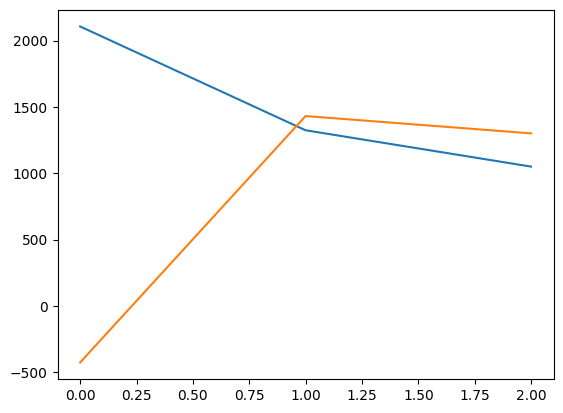

In [26]:
diff_values = difference(raw_values000, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=600.037255, Expected=2107.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=1918.247491, Expected=1324.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=1424.040330, Expected=1050.000000
Test RMSE: 959.856
Test MAE: 825.084


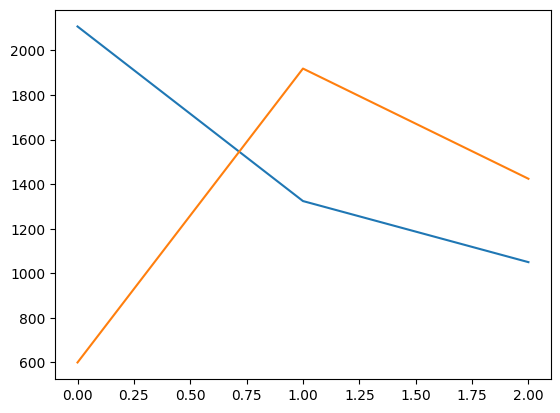

In [27]:
diff_values = difference(raw_values0000, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=923.387769, Expected=2107.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=2485.152419, Expected=1324.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=298.454749, Expected=1050.000000
Test RMSE: 1051.036
Test MAE: 1032.103


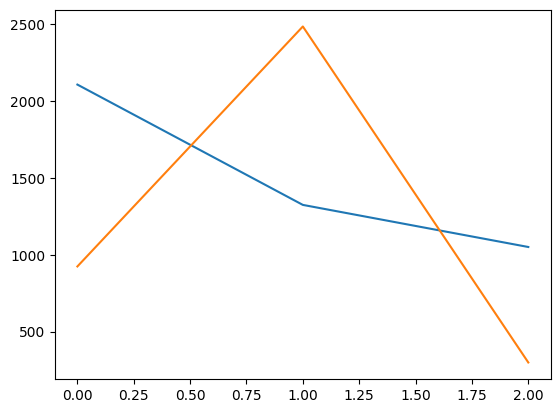

In [28]:
diff_values = difference(raw_values00000, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 1

In [29]:
diff_values2 = difference(raw_values2, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values2, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 2ms/step


array([[-0.0173964 ],
       [-0.49174806],
       [ 0.07670075],
       [-0.31426865],
       [-0.20300771],
       [ 0.04285147],
       [-0.5269712 ],
       [ 0.13016455],
       [ 0.16840383],
       [ 0.04839576],
       [-0.39595973],
       [-0.17190339],
       [-0.04515528],
       [-0.10894033],
       [-0.24102396],
       [ 0.17623775],
       [-0.21582022],
       [-0.27565438],
       [ 0.16504188],
       [ 0.03553454],
       [-0.05503739],
       [ 0.06192234],
       [-0.12978801],
       [-0.08876026],
       [-0.41357577],
       [ 0.09983458],
       [-0.11529148],
       [-0.24378258],
       [-0.33556885],
       [ 0.09137116],
       [ 0.2820026 ],
       [-0.17071435],
       [-0.30451497],
       [ 0.04200915],
       [ 0.35446402],
       [-0.371783  ],
       [-0.06711054],
       [-0.19702485],
       [ 0.03693291],
       [-0.05574131],
       [-0.2938134 ],
       [ 0.28684732],
       [ 0.37055162],
       [ 0.34194785]], dtype=float32)

In [30]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values2, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values2[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=357.912283, Expected=53.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=199.442829, Expected=185.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=260.908456, Expected=52.000000


Test RMSE: 213.559
Test MAE: 176.088


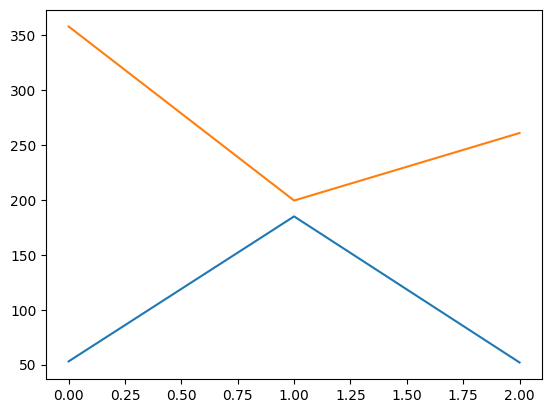

In [31]:
# report performance
rmse = sqrt(mean_squared_error(raw_values2[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values2[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values2[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 23ms/step
Month=1, Predicted=939.386667, Expected=2107.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=2136.755033, Expected=1324.000000
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=1283.423529, Expected=1050.000000
Test RMSE: 832.342
Test MAE: 737.931


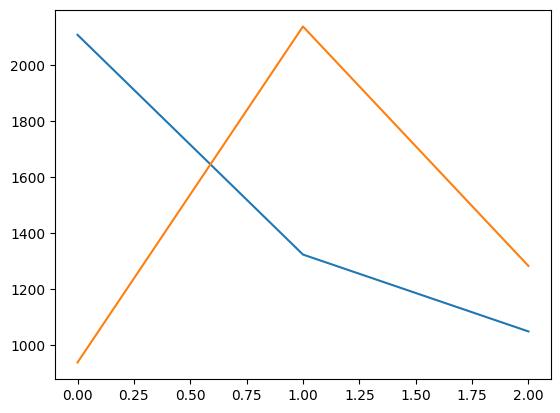

In [32]:
diff_values = difference(raw_values22, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=892.442605, Expected=2107.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=2193.860872, Expected=1324.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=1287.676739, Expected=1050.000000
Test RMSE: 873.365
Test MAE: 774.032


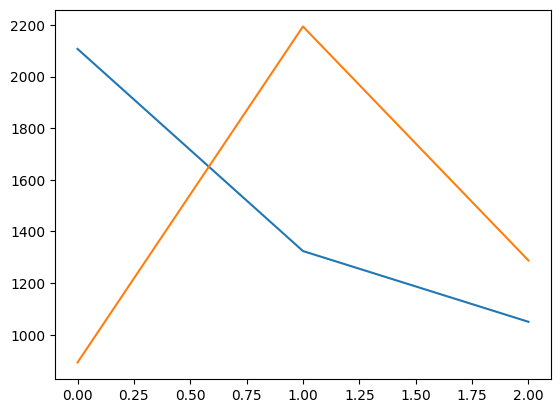

In [33]:
diff_values = difference(raw_values222, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=1152.327217, Expected=2107.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=2077.965578, Expected=1324.000000
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=1248.758942, Expected=1050.000000
Test RMSE: 711.658
Test MAE: 635.799


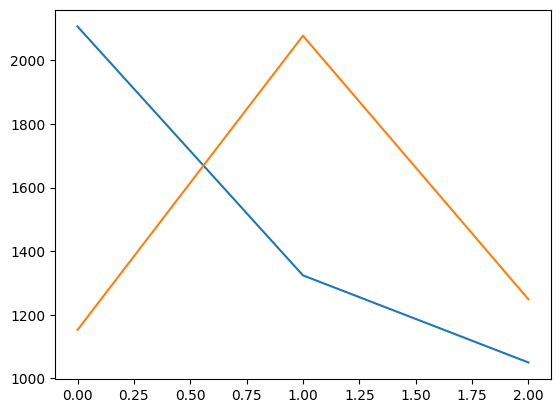

In [35]:
diff_values = difference(raw_values22222, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 2

In [36]:
diff_values3 = difference(raw_values3, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values3, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 2ms/step


array([[-1.28038228e-04],
       [-2.30117634e-01],
       [-1.53680265e-01],
       [-5.01038194e-01],
       [-2.44324416e-01],
       [-1.22774988e-01],
       [-2.97779024e-01],
       [-1.32905737e-01],
       [-4.67493571e-03],
       [-3.64316881e-01],
       [ 3.11416060e-01],
       [ 5.71417585e-02],
       [-3.34148437e-01],
       [-2.42897987e-01],
       [-2.20309675e-01],
       [-4.09628779e-01],
       [ 2.71147609e-01],
       [-4.85227853e-01],
       [ 1.63234100e-01],
       [-1.97741210e-01],
       [ 3.08723569e-01],
       [-4.14687321e-02],
       [-4.82927293e-01],
       [-4.19762880e-01],
       [ 1.69943571e-02],
       [ 3.04730892e-01],
       [ 6.83538169e-02],
       [-5.17630517e-01],
       [-1.40201703e-01],
       [-2.03447208e-01],
       [-2.61258572e-01],
       [-5.64723983e-02],
       [ 4.61366065e-02],
       [-1.96721926e-01],
       [-4.00887251e-01],
       [ 1.22364536e-01],
       [-2.01290980e-01],
       [-1.23337731e-01],
       [-4.1

In [37]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values3, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values3[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 22ms/step
Month=1, Predicted=2839.421269, Expected=2889.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=2760.463878, Expected=2209.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=2524.776620, Expected=2589.000000


Test RMSE: 321.815
Test MAE: 221.755


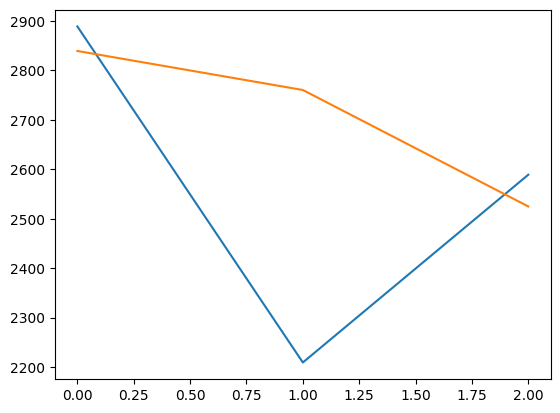

In [38]:
# report performance
rmse = sqrt(mean_squared_error(raw_values3[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values3[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values3[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 15ms/step
Month=1, Predicted=823.300095, Expected=2107.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=1835.471939, Expected=1324.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=1925.201160, Expected=1050.000000
Test RMSE: 944.363
Test MAE: 890.124


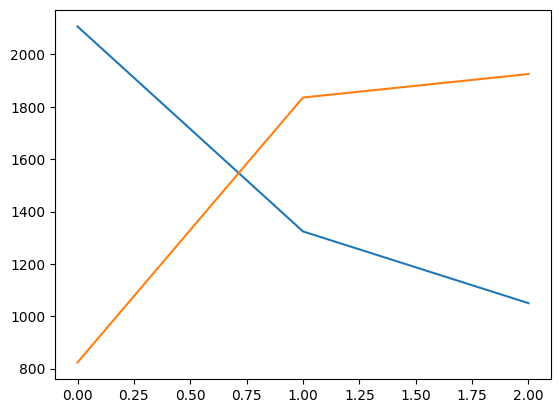

In [39]:
diff_values = difference(raw_values33, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=1407.605029, Expected=2107.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=2695.722054, Expected=1324.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=723.007037, Expected=1050.000000
Test RMSE: 908.790
Test MAE: 799.370


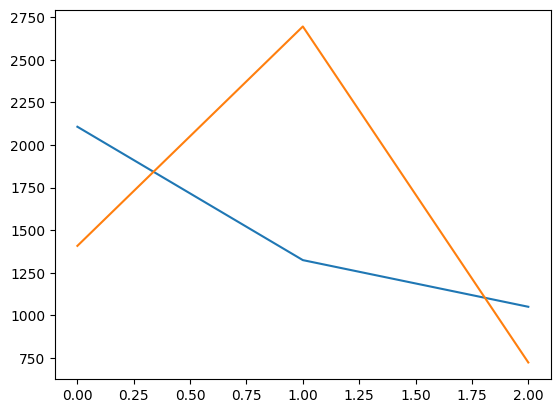

In [40]:
diff_values = difference(raw_values333, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=742.578951, Expected=2107.000000
1/1 [==============================] - 0s 15ms/step
Month=2, Predicted=2242.891296, Expected=1324.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=1778.351872, Expected=1050.000000
Test RMSE: 1038.669
Test MAE: 1003.888


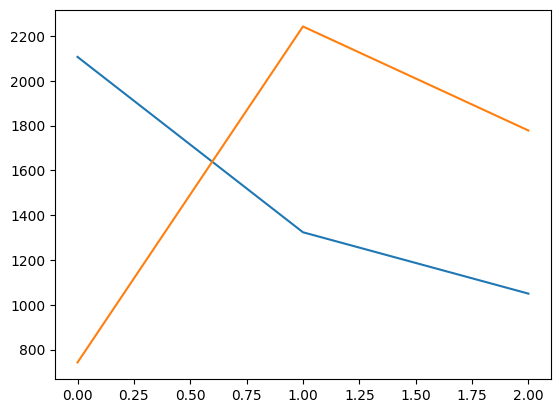

In [41]:
diff_values = difference(raw_values3333, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=778.393680, Expected=2107.000000
1/1 [==============================] - 0s 17ms/step
Month=2, Predicted=2592.886534, Expected=1324.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=1129.656227, Expected=1050.000000
Test RMSE: 1061.699
Test MAE: 892.383


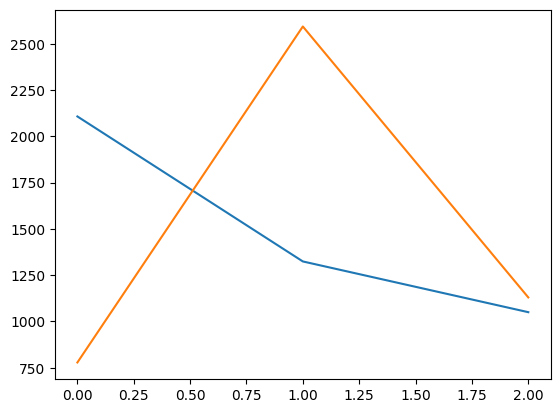

In [42]:
diff_values = difference(raw_values33333, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()